### Why MLE (Maximum Likelihood Estomation)

- MLE in a nutshell helps us answer this question:
              Which are the best parameters/coefficients for my model? 
### Checkout my Blog [here](https://www.vaishalilambe.com)

Because, while MLE gives a spot estimate — which is common to frequentist outputs — it can be considered a special case of maximum a posteriori (MAP) estimation, where we use a naïve prior and never bother to update it.

In [18]:
# import libraries
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [26]:
# generate data
N = 100
X = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
Y = 3*x + ϵ
df = pd.DataFrame({'y':Y, 'x':X})
df['constant'] = 1

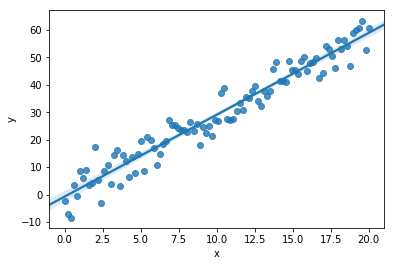

In [27]:
# plot
sns.regplot(df.x, df.y);

Modeling OLS with Statsmodels
- Since we created regression-like, continuous data, we will use sm.OLS to calculate the best coefficients and Log-likelihood (LL) as a benchmark.

In [28]:
# split features and target
X = df[['constant', 'x']]
# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1263.
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           8.50e-58
Time:                        13:01:19   Log-Likelihood:                -297.01
No. Observations:                 100   AIC:                             598.0
Df Residuals:                      98   BIC:                             603.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       1.5425      0.946      1.631      0.106      -0.335       3.420
x              2.9041      0.082     35.541      0.000       2.742       3.066
==============================================================================
Omnibus:                        4.822   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                4.151
Skew:                           0.457   Prob(JB):                        0.126
Kurtosis:                       3.400   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Maximizing LL to solve for Optimal Coefficients

In [29]:
# define likelihood function
def MLERegression(params):
 intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
 yhat = intercept + beta*x # predictions
# next, we flip the Bayesian question
# compute PDF of observed values normally distributed around mean (yhat)
# with a standard deviation of sd
 negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
# return negative LL
 return(negLL)

In [31]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', 
 options={'disp': True})

Optimization terminated successfully.
         Current function value: 297.011860
         Iterations: 115
         Function evaluations: 206


In [32]:
results # this gives us verbosity around our minimization
# notice our final key and associated values…

 final_simplex: (array([[1.54255039, 2.90405273, 4.71702681],
       [1.54248767, 2.90405209, 4.71702225],
       [1.54250592, 2.90405213, 4.71707614],
       [1.54264196, 2.90403985, 4.71703926]]), array([297.01186039, 297.0118604 , 297.0118604 , 297.0118604 ]))
           fun: 297.01186039411465
       message: 'Optimization terminated successfully.'
          nfev: 206
           nit: 115
        status: 0
       success: True
             x: array([1.54255039, 2.90405273, 4.71702681])

In [33]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf.head(2), 4)

,coef
constant,1.5426
x,2.9041


####  above we can see the OLS and MLE number match ups nicely 

## Maximum Likelihood Estimation of Custom Models in Python with StatsModels

In this post, we will use the parameter values π=0.3 and λ=2

The probability mass function of the zero-inflated Poisson distribution is shown below, next to a normal Poisson distribution, for comparison.

In [12]:
from __future__ import division

from matplotlib import  pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

np.random.seed(123456789)

In [4]:
pi = 0.3
lambda_ = 2.

In [5]:
def zip_pmf(x, pi=pi, lambda_=lambda_):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

### Maximum likelihood estimation

First we generate 1,000 observations from the zero-inflated model.

In [6]:
N = 1000

inflated_zero = stats.bernoulli.rvs(pi, size=N)
x = (1 - inflated_zero) * stats.poisson.rvs(lambda_, size=N)

We are now ready to estimate π
 and λ
 by maximum likelihood. To do so, we define a class that inherits from statsmodels’ GenericLikelihoodModel as follows.

In [7]:
class ZeroInflatedPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(ZeroInflatedPoisson, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi = params[0]
        lambda_ = params[1]

        return -np.log(zip_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros, lambda_start])
            
        return super(ZeroInflatedPoisson, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

The key component of this class is the method nloglikeobs, which returns the negative log likelihood of each observed value in endog. Secondarily, we must also supply reasonable initial guesses of the parameters in fit. Obtaining the maximum likelihood estimate is now simple.

In [8]:
model = ZeroInflatedPoisson(x)
results = model.fit()

Optimization terminated successfully.
         Current function value: 1.586641
         Iterations: 37
         Function evaluations: 70


In [9]:
pi_mle, lambda_mle = results.params

pi_mle, lambda_mle

(0.31542487710071976, 2.0451304204850853)

We also gain access to many of statsmodels’ built in model analysis tools. For example, we can use bootstrap resampling to estimate the variation in our parameter estimates.

In [11]:
boot_mean, boot_std, boot_samples = results.bootstrap(nrep=500, store=True)
boot_pis = boot_samples[:, 0]
boot_lambdas = boot_samples[:, 1]

<class '__main__.ZeroInflatedPoisson'>
